# tile llc model run and distribute parcels runs


To do:

- [ ] try with different interpolation schemes
- [ ] try with different compiler?
- [X] add online horizontal speed output
- [X] change run tree
- [X] add tracer and sea level interpolation. Pressure will always be recomputed offline
- [X] on the fly parcel seeding


In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
#import geopandas

import dask
#from dask.delayed import delayed

#from xmitgcm.llcreader import llcmodel as llc

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

processing = 1

if processing==0:
    cluster = LocalCluster()
elif processing==1:
    # parcels simulation
    cluster = PBSCluster(processes=4, cores=4, walltime='48:00:00')
#    w = cluster.scale(jobs=13)
    w = cluster.scale(jobs=1)
elif processing==2:
    # post processing
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.217:8787/status,
Dashboard: http://10.148.0.217:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.217:47011,Workers: 0
Dashboard: http://10.148.0.217:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## setup directories and run parameters

In [3]:
#root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/datawork/aponte/parcels/'
root_dir = '/home1/scratch/slgentil/parcels/'

# 5x5 tiles dij=100 T=365 5jobs x 5workers
#run_name = 'global_T365j_dt1j_dij50'
#run_name = 'debug'
run_name = 'californie_T30j_dt1j_dij50'

In [4]:
# simulation parameters

T = 1. # length of the total run [days]
#T = 360 # length of the total run [days]
dt_window = timedelta(days=T) 
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)
dt_seed = 10 # in days
restart = 0 # 0: no restart, -1: last index, precise index otherwise
init_dij = 10 # initial position subsampling compared to llc grid

overwrite = False

lonmin=-130.
lonmax=-120.
latmin=31.5
latmax=39.5

In [5]:
# create run directory tree
dirs = pa.create_dir_tree(root_dir, run_name, overwrite=overwrite)

Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50
Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run
Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/tiling
Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/parquets
Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/diagnostics


---

## load llc data

In [6]:
# load llc data
ds = ut.load_data(V=['SSU', 'SSV', 'Eta', 'SST', 'SSS'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])

/home1/datahome/slgentil/mit_equinox/mitequinox/utils.py:158: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(ref_data_dir + v + ".zarr")
/home1/datahome/slgentil/mit_equinox/mitequinox/utils.py:158: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Ex

---

## create tiles

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [7]:
create_tiles = True
#create_tiles = overwrite

if create_tiles:
    # create tiling
    _ds = grd.reset_coords().persist()
    tl = pa.tiler(ds=_ds, factor=(1, 1), overlap=(250, 250), 
                  global_llc=False, lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)
    # store tiler
    tl.store(dirs["tiling"])
else:
    tl = pa.tiler(tile_dir=dirs["tiling"])

Tiler stored in /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/tiling


In [8]:
tl.create_tile_run_tree(dirs["run"], overwrite=overwrite)

Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run/data_000


--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted within tile_store_llc)


In [9]:
def format_info(step, t_start, t_end):
    print('-------------------------------------------')
    print('step={}  /  start={}  /  end={}'
          .format(step,
                  t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                 )
         )

In [10]:


t_start = ut.np64toDate(ds['time'][0].values)
t_end = t_start + int(T/dt_window.days)*dt_window

print('Global start = {}  /  Global end = {} '
      .format(t_start.strftime("%Y-%m-%d:%H"),
              t_end.strftime("%Y-%m-%d:%H"),
             )
     )

# get new log filename for this run
log_file = pa.name_log_file(dirs['run'])

if restart==-1:
    log = pa.browse_log_files(dirs['run'])
    if log:
        restart = max(list(log))+1
    else:
        restart = 0

# clean up data for restart
tl.clean_up(dirs["run"], restart)

if restart==0:
    global_parcel_number = 0
    local_numbers = {tile: 0 for tile in range(tl.N_tiles)}
    max_ids = {tile: None for tile in range(tl.N_tiles)}
else:
    #print(log, restart)
    _log = log[restart-1]
    global_parcel_number = _log['global_parcel_number']
    #local_numbers = _log['local_numbers'] # TMP !!!
    max_ids = _log['max_ids']

# skips steps if restart
step_t = list(enumerate(ut.dateRange(t_start, t_end, dt_window)))[restart:]

for step, local_t_start in step_t:
    
    local_t_end = local_t_start+dt_window
    
    # print step info
    format_info(step, local_t_start, local_t_end)

    # load, tile (and store) llc data
    ds_tiles = pa.tile_store_llc(ds,
                                 slice(local_t_start, local_t_end, None),
                                 tl,
                                 netcdf=False,
                                 global_llc=False,
                                 lonmin=lonmin, lonmax=lonmax,
                                 latmin=latmin, latmax=latmax
                                )
    
    global_parcel_number0 = global_parcel_number
        
    #for tile in range(tl.N_tiles):
    tile = 0
    step_out = \
            pa.step_window(tile, step, 
                           local_t_start, local_t_end,
                           dt_window, dt_step, dt_outputs, 
                           tl,
                           ds_tile=ds_tiles[tile], 
                           init_dij=init_dij, 
                           parcels_remove_on_land=True,
                           pclass="extended",
                           id_max=max_ids[tile],
                          )

    # update number of parcels and maximum ids for each tiles
    global_parcel_number = int(step_out[0])
    max_ids = {tile: int(step_out[1])}
    local_numbers = {tile: int(step_out[0])}
    log = dict(global_parcel_number=global_parcel_number,
               local_numbers=local_numbers,
               max_ids=max_ids,
              )
    # store log
    pa.store_log(log_file, step, log)
        
    print('Total number of particles = {}  ({:+d})'
          .format(global_parcel_number, 
                  global_parcel_number-global_parcel_number0,
                 )
         )
    

Global start = 2011-11-15:00  /  Global end = 2011-11-16:00 
delete /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run/data_000/floats_000_000.nc
-------------------------------------------
step=0  /  start=2011-11-15:00  /  end=2011-11-16:01


INFO: Compiled ArrayParticle_extendedRemoveOnLand ==> /dev/shm/pbs.6542568.datarmor0/parcels-16088/lib5b56344fb583e2a25e11e1162305041c_0.so
INFO: Compiled ArrayParticle_extendedExtended_SampleAdvectionRK4 ==> /dev/shm/pbs.6542568.datarmor0/parcels-16088/lib00efc6ac8b0e0e0bba738233fa8f782c_0.so
/home1/datahome/slgentil/conda-env/equinox/lib/python3.8/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Total number of particles = 1435  (+1435)


In [11]:
print(log_file)

/home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run/log_20210902_1414.yaml


<xarray.Dataset>
Dimensions:  (time: 26, j: 512, i: 480)
Coordinates: (12/19)
  * time     (time) datetime64[ns] 2011-11-15 ... 2011-11-16T01:00:00
    niter    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) int64 9650 9651 9652 9653 9654 ... 10158 10159 10160 10161
  * i        (i) int64 12864 12865 12866 12867 12868 ... 13340 13341 13342 13343
    XC       (j, i) float32 dask.array<chunksize=(512, 480), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(512, 480), meta=np.ndarray>
    ...       ...
    dxC      (j, i) float32 dask.array<chunksize=(512, 480), meta=np.ndarray>
    dyC      (j, i) float32 dask.array<chunksize=(512, 480), meta=np.ndarray>
    dxG      (j, i) float32 dask.array<chunksize=(512, 480), meta=np.ndarray>
    dyG      (j, i) float32 dask.array<chunksize=(512, 480), meta=np.ndarray>
    rAs      (j, i) float32 dask.array<chunksize=(512, 480), meta=np.ndarray>
    rAw      (j, i) float32 dask.array<chunksize=(512, 480), 

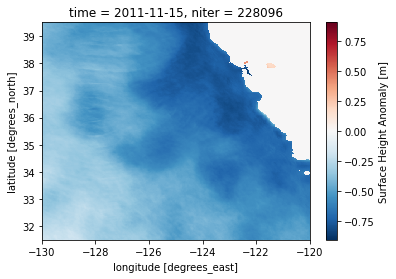

In [12]:
print(ds_tiles[0])
ds_tiles[0].Eta.isel(time=0).plot.pcolormesh(x='XC',y='YC')

In [13]:
cluster.close()

In [14]:
#ds_tiles = [_ds.persist() for _ds in ds_tiles]
# 220GB in RAM against 750 GB observed

In [15]:
client.restart()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.client - ERROR - Restart timed out after 20.00 seconds


<Client: No scheduler connected>

---

## quick pick

In [16]:
df = pa.load_nc(dirs["run"], index='time', persist=True)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15 00:00:00,0,31.676224,-127.281250,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
2011-11-15 01:00:00,0,31.674299,-127.286032,0.0,-1.451697e-06,-8.537885e-07,-0.331844,17.736940,33.353992
2011-11-15 02:00:00,0,31.674195,-127.290559,0.0,-1.231321e-06,-2.301792e-07,-0.271026,17.729099,33.353439
2011-11-15 03:00:00,0,31.673948,-127.294622,0.0,-1.276450e-06,1.729150e-07,-0.132524,17.721241,33.353344
2011-11-15 04:00:00,0,31.673906,-127.298581,0.0,-9.770854e-07,-3.124829e-07,0.036952,17.714066,33.353542


In [22]:
tmin = str(df.index.min().compute() )
tmax = str(df.index.max().compute())
print(tmin, tmax)

2011-11-15 00:00:00 2011-11-16 01:00:00


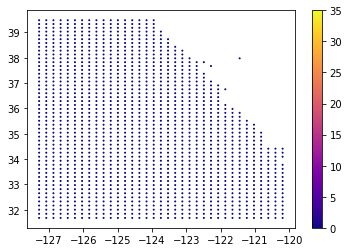

In [23]:

_df = df.loc[tmin].compute()
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.colorbar()

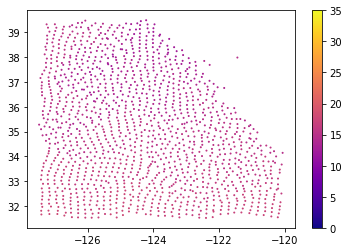

In [24]:
_df = df.loc[tmax, :].compute()
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.colorbar()

---
## load netcdf file and store in parquet format
faster to reload from the netcdf files with right index than to change index of the dask dataframe

In [20]:
ds, dirs = pa.load_logs(root_dir, run_name)

TypeError: 'NoneType' object is not iterable

### save with time index

In [ ]:
%%time
df = pa.load_nc(dirs["run"], index='time')
pa.store_parquet(dirs["parquets"], df, index='time', overwrite=True)

### save with trajectory id index

In [ ]:
%%time
df = pa.load_nc(dirs["run"], index='trajectory')
pa.store_parquet(dirs["parquets"], df, index='trajectory', overwrite=True)

### save with H3 geographic index

In [ ]:
%%time
df = pa.load_nc(dirs["run"], index='trajectory')
df = pa.h3_index(df)
pa.store_parquet(dirs["parquets"], df, index='hex_id', overwrite=True)

## Close cluster

In [ ]:
cluster.close()